In [1]:
from __future__ import print_function, division

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import qgrid

import numpy as np
from numpy import diff
import math

import pandas as pd
import xarray as xr

import climlab
from climlab.solar.insolation import daily_insolation
from climlab.radiation import DailyInsolation
from climlab.radiation import FixedInsolation
from climlab.process import TimeDependentProcess


from IPython.display import HTML



import scipy as scp
from attrdict import AttrDict
from datetime import datetime

import dask.dataframe as dd

import warnings


In [8]:
#create simple temperature, pressure, altitude profile
temperature = np.array([200.,200.,200.,200.])
pressure = np.array([683,684,685,686])
#long altitude
altitude = np.array([2857,2757,2657,2557])
altitude_bounds = np.array([2900,2800,2700,2600])
#short altitude (leads to really high turbulence)
#altitude = np.array([2857,2847,2837,2827])
#altitude_bounds = np.array([2862,2852,2842,2832])

CO2 = .00038

# Climlab

In [9]:
###### create a Turbulence class #######
class Turbulence(TimeDependentProcess):
    #class turbulence that decays with height computed from:
    # theta = Tatm(P0/Patm)^R/Cp
    # k0 = Net surface flux/(dtheta/dz) at surface 
    # ka = k0*exp(-z/d) in atmosphere
    # -ka * dtheta/dz is turbulent flux in the atmosphere 
    def __init__(self, **kwargs):
        super(Turbulence, self).__init__(**kwargs)
        self.time_type = 'explicit'
        #self._hr = {}
        #for var in self.state:
            #self._hr[var] = 0. *self.state[var] #create a Tatm and Ts for our self._hr that is the length of that variable in our state
        ### define new levels
        #n+1 pressure level (lev_boundsin climlab) reworked so that we are no longer using 0 and 1000 as our TOA and surface
        self.lev_bounds[0] = self.lev_bounds[1]-2*(self.lev_bounds[1] - self.lev[0])
        self.lev_bounds[-1] = self.lev_bounds[-2]+2*(self.lev[-1] - self.lev_bounds[-2])
        #altitude (n)
        self._z = altitude - altitude[-1]
        #altitude bounds (n) relative to ground
        self._z_bounds = np.zeros(len(state['Tatm']) +1)
        self._z_bounds =  altitude_bounds - altitude[-1]
        ### calculate turbulent flux
        #surface flux (LW + SW)
        self._total_sfc_flux_init = (rad.diagnostics['SW_sfc_clr']- rad.diagnostics['LW_sfc_clr']) #W/m^2
        #gas constant / specific heat of air
        R = 287 #gas constant of air J/kg*K (at 250 K)
        cp_air = 1003 #specific heat of air (at 250 K) J/(kg*K)
        density = 1.05 #density of air kg/m^3
        self.R_cp = R/cp_air 
        self._theta_init = np.zeros(len(state['Tatm']) +1)
        self._theta_init[:-1] = self.state['Tatm']*((pressure[-1]/self.lev)**(self.R_cp))#K
        self._theta_init[-1] = self.state['Ts']*((pressure[-1]/pressure[-1])**(self.R_cp))
        #dtheta_dz_init (just need the first value of dtheta/dz)
        self._dtheta_dz_surf_init = (np.diff(self._theta_init)/np.diff(self._z))[-1] #K/m
        #surface diffk (m2/s)
        self._surface_diffk = 1
        #atmospheric diffk
        scale_factor = 100 #m
        self._atm_diffk = self._surface_diffk * (np.exp(-self._z_bounds/scale_factor)) #m^2/s
        

    def _compute(self):
        #constants
        cp_air = 1003 #specific heat of air (at 250 K) J/(kg*K)
        density = 1.05 #density of air kg/m^3
        #surface flux (LW + SW)
        self._total_sfc_flux = (rad.diagnostics['SW_sfc_clr']- rad.diagnostics['LW_sfc_clr']) #W/m^2
        #theta (length of n)
        self._theta = np.zeros(len(state['Tatm']) +1)
        self._theta[:-1] = self.state['Tatm']*((pressure[-1]/self.lev)**(self.R_cp))#K
        self._theta[-1] = self.state['Ts']*((pressure[-1]/pressure[-1])**(self.R_cp))
        #dtheta_dz_init (length of n+1)
        self._dtheta_dz = np.zeros(len(state['Tatm']) +1)
        self._dtheta_dz[1:] = np.diff(self._theta)/np.diff(self._z)
        self._dtheta_dz[0] =  0 #TOA flux will be zero so we prescribe dtheta/dz as zero
        #calculate the turbulent flux
        self._atm_turbulent_flux = -self._atm_diffk * self._dtheta_dz #K*m/s
        #calculate/prescribe surface turbulent flux
        self._sfc_turbulent_flux = self._total_sfc_flux/(cp_air*density)
        # calculate heating rate (flux convergence) from flux and convert into K/day (which is the heating rate output in climlab)
        self._atm_hr = (np.diff(self._atm_turbulent_flux)/np.diff(self._z_bounds)) * climlab.constants.seconds_per_day #K/day
        self._sfc_hr= np.array((self._atm_turbulent_flux[-1]-self._sfc_turbulent_flux)/(self._z_bounds[-1]-self._z[-1]) * climlab.constants.seconds_per_day) #K/day
        self._hr = np.concatenate([ram.subprocess.Turbulence._atm_hr,ram.subprocess.Turbulence._sfc_hr])
        tendencies = {'Tatm' : self._atm_hr, 'Ts' : self._sfc_hr}
        
        # check that CFL condition is met
        self._CFL = self._surface_diffk*(self.time['timestep']/(np.diff(self._z_bounds)**2))[-1] 
        if self._CFL > 1.:
            warnings.warn(f"CFL Condition not met, {self._CFL}, timestep too large or lower level z difference too small")
        return tendencies

In [10]:
####### set up climlab ########
albedo = .8 
timestep = 20. 

#set up the radiative-advective model (ram)
ram_dict = {} #create our ram_dict for the output of each instance of ram (2 experiments x 6 CO2 levels x 12 months)

###create ram state, radiation model, and TimeDepedent ram model instance

#create two domains: atm and surface
sfc, atm=climlab.domain.single_column(lev=pressure[:-1]);
#create an atmospheric state
state = AttrDict()
#set up a surface temperature profile 
T_s=climlab.Field(temperature[-1], domain=sfc);
state['Ts']=T_s #K
#set up an atmospheric temperature profile
T_atm=climlab.Field(temperature[:-1], domain=atm);
state['Tatm']=T_atm #K

#radiation model setup
rad = climlab.radiation.RRTMG(name='Radiation(all gases)', state = state,
                                  albedo = albedo,
                                  timestep = timestep,
                                  ozone_file = None
                                  )
rad.absorber_vmr['CO2'] = CO2 #kg/kg
#create ram
ram = climlab.TimeDependentProcess(state = state, timestep = timestep)
#add latitude axis
lat = climlab.domain.axis.Axis(axis_type='lat', points=-90.)
ram.domains['Ts'].axes['lat'] = lat
#add radiation
ram.add_subprocess('Radiation', rad)
#compute ram
ram.compute()
#turbulence model setup (coupled to rad model, experiment, and month)
turb = Turbulence(name = 'Turbulence', state=state, rad = rad, timestep = timestep)
#add turbulence
ram.add_subprocess('Turbulence', turb) #add insolation subprocess
#compute ram
ram.compute()
#advective model setup (coupled to rad model)
adv = climlab.process.external_forcing.ExternalForcing(state = state, turb = turb, ram = ram)
adv.forcing_tendencies['Tatm'] = -((np.asarray(ram.TdotSW_clr - ram.TdotLW_clr) - turb._atm_hr))
#add advection
ram.add_subprocess('Advection', adv)
#compute ram
ram.compute()
#add to dictionary
ram_dict = ram


In [11]:
ram.subprocess.Turbulence._z_bounds

array([343, 243, 143,  43])

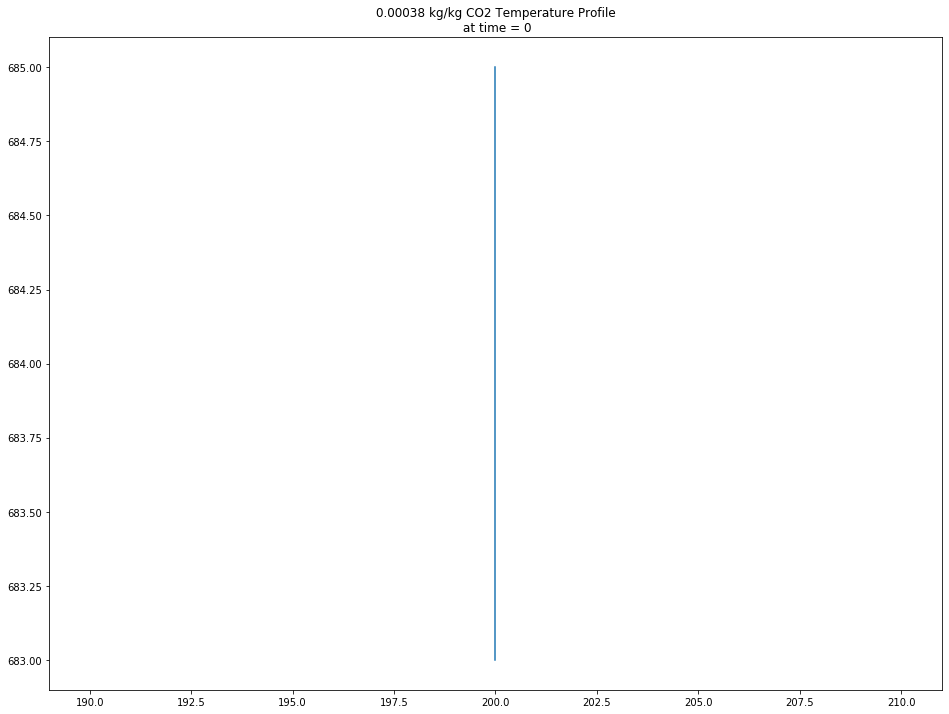

In [245]:
##### plot our initial timestep #####
fig = plt.figure(figsize = [16,12])
fig.subplots_adjust(hspace=.2, wspace=.4)
ax = plt.subplot()
plt.title(f'{CO2} kg/kg CO2 Temperature Profile\n at time = {ram_dict.time["steps"]}')
ax.plot(ram_dict.state['Tatm'], ram_dict.lev);

Text(0, 0.5, 'Altitude (m)')

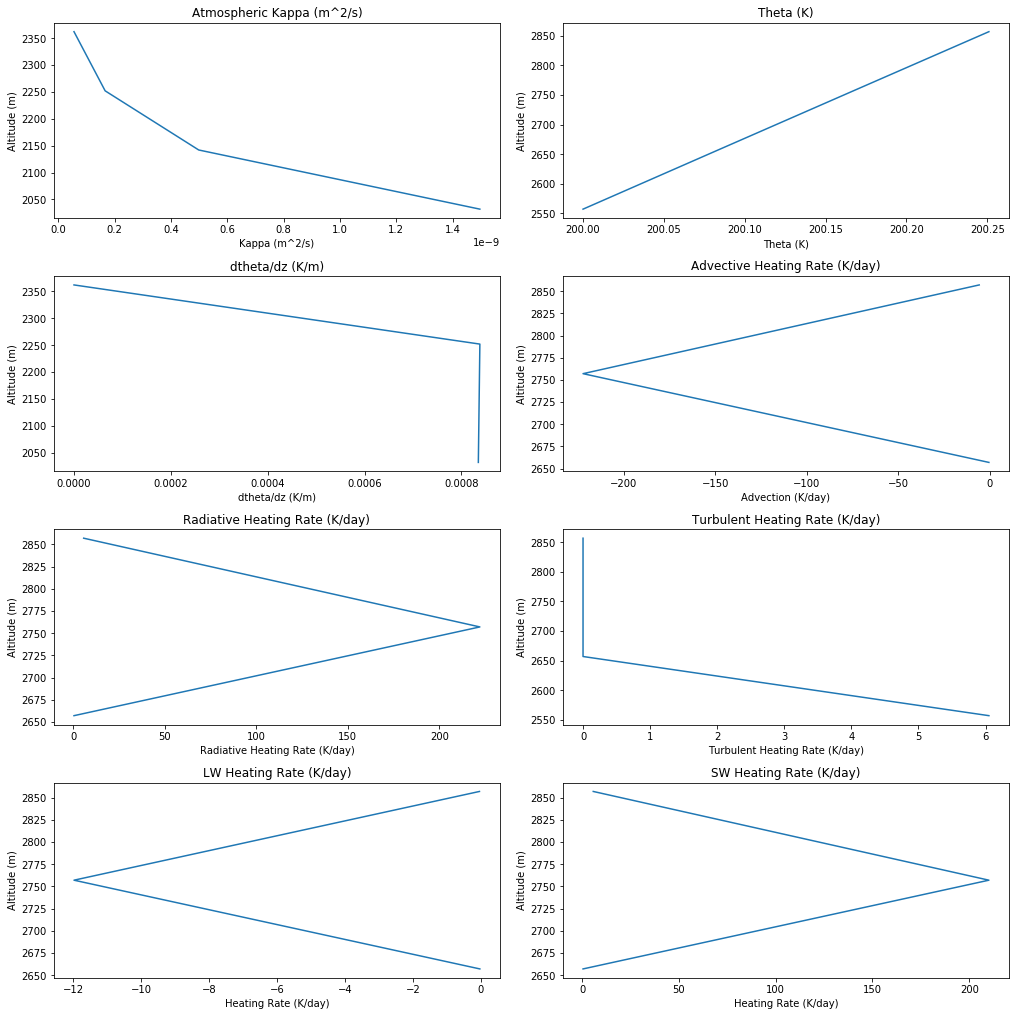

In [246]:
#### plot diagnostics to see turbulence, theta, dtheta/dz ####

fig, ax = plt.subplots(4,2,figsize = (14,14), constrained_layout=True)
ax[0,0].plot(ram_dict.subprocess.Turbulence._atm_diffk, ram_dict.subprocess.Turbulence._z_bounds) 
ax[0,0].set_title('Atmospheric Kappa (m^2/s)')
ax[0,0].set_xlabel('Kappa (m^2/s)')
ax[0,0].set_ylabel('Altitude (m)')
ax[0,1].plot(ram_dict.subprocess.Turbulence._theta_init, ram_dict.subprocess.Turbulence._z)
ax[0,1].set_title('Theta (K)')
ax[0,1].set_xlabel('Theta (K)')
ax[0,1].set_ylabel('Altitude (m)')

ax[1,0].plot(ram_dict.subprocess.Turbulence._dtheta_dz, ram_dict.subprocess.Turbulence._z_bounds)
ax[1,0].set_title('dtheta/dz (K/m)')
ax[1,0].set_xlabel('dtheta/dz (K/m)')
ax[1,0].set_ylabel('Altitude (m)')

ax[1,1].plot(ram_dict.subprocess.Advection.forcing_tendencies['Tatm'], ram_dict.subprocess.Turbulence._z[:-1])
ax[1,1].set_title('Advective Heating Rate (K/day)')
ax[1,1].set_xlabel('Advection (K/day)')
ax[1,1].set_ylabel('Altitude (m)')

ax[2,1].plot(ram_dict.subprocess.Turbulence._hr, ram_dict.subprocess.Turbulence._z)
ax[2,1].set_title('Turbulent Heating Rate (K/day)')
ax[2,1].set_xlabel('Turbulent Heating Rate (K/day)')
ax[2,1].set_ylabel('Altitude (m)')

ax[2,0].plot((ram_dict.TdotSW_clr-ram_dict.TdotLW_clr), ram_dict.subprocess.Turbulence._z[:-1])
ax[2,0].set_title('Radiative Heating Rate (K/day)')
ax[2,0].set_xlabel('Radiative Heating Rate (K/day)')
ax[2,0].set_ylabel('Altitude (m)')

ax[3,0].plot((ram_dict.TdotLW_clr), ram_dict.subprocess.Turbulence._z[:-1])
ax[3,0].set_title('LW Heating Rate (K/day)')
ax[3,0].set_xlabel('Heating Rate (K/day)')
ax[3,0].set_ylabel('Altitude (m)')

ax[3,1].plot((ram_dict.TdotSW_clr), ram_dict.subprocess.Turbulence._z[:-1])
ax[3,1].set_title('SW Heating Rate (K/day)')
ax[3,1].set_xlabel('Heating Rate (K/day)')
ax[3,1].set_ylabel('Altitude (m)')

# Timestep forward

In [247]:
ram_dict.step_forward()

In [248]:
ram_dict.state['Tatm']

Field([   85.17054172, -4243.39220209,   191.07070961])

In [249]:
ram_dict.state['Ts']

Field([321.00422279])

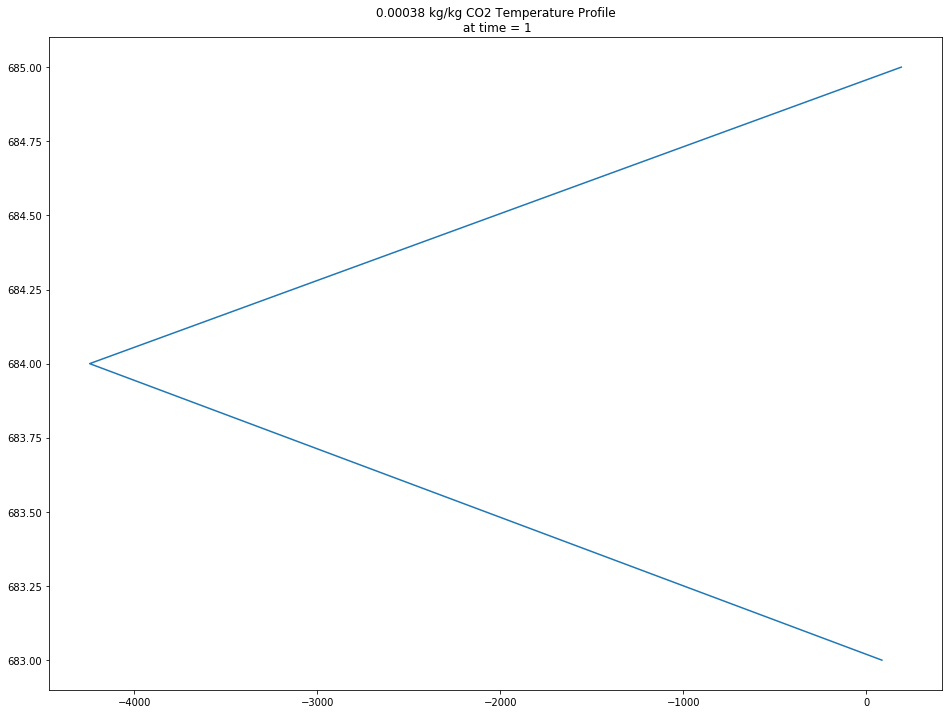

In [250]:
##### plot our timestep forward #####
fig = plt.figure(figsize = [16,12])
fig.subplots_adjust(hspace=.2, wspace=.4)
ax = plt.subplot()
plt.title(f'{CO2} kg/kg CO2 Temperature Profile\n at time = {ram_dict.time["steps"]}')
ax.plot(ram_dict.state['Tatm'], ram_dict.lev)

AttributeError: 'AttrDict' instance has no attribute 'Advection'

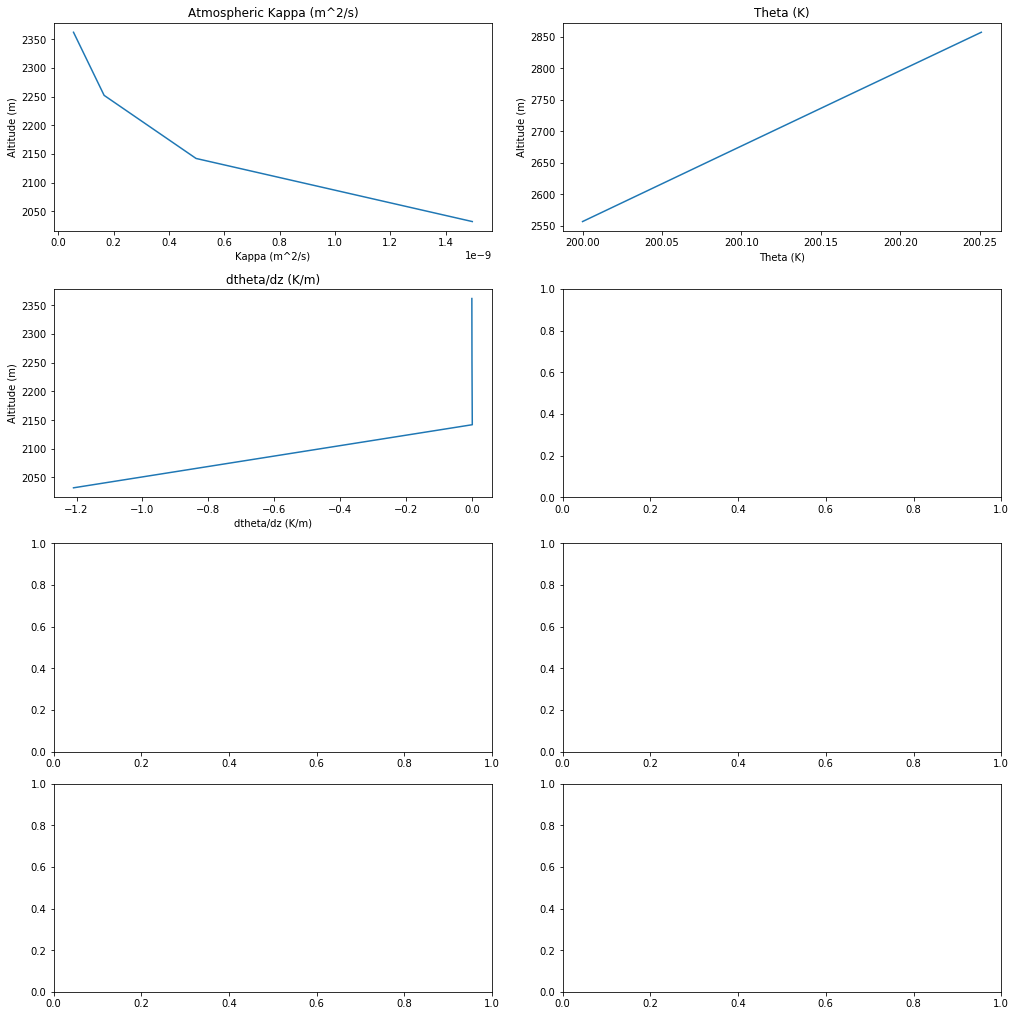

In [234]:
#### plot diagnostics to see turbulence, theta, dtheta/dz ####

fig, ax = plt.subplots(4,2,figsize = (14,14), constrained_layout=True)
ax[0,0].plot(ram_dict.subprocess.Turbulence._atm_diffk, ram_dict.subprocess.Turbulence._z_bounds) 
ax[0,0].set_title('Atmospheric Kappa (m^2/s)')
ax[0,0].set_xlabel('Kappa (m^2/s)')
ax[0,0].set_ylabel('Altitude (m)')
ax[0,1].plot(ram_dict.subprocess.Turbulence._theta_init, ram_dict.subprocess.Turbulence._z)
ax[0,1].set_title('Theta (K)')
ax[0,1].set_xlabel('Theta (K)')
ax[0,1].set_ylabel('Altitude (m)')

ax[1,0].plot(ram_dict.subprocess.Turbulence._dtheta_dz, ram_dict.subprocess.Turbulence._z_bounds)
ax[1,0].set_title('dtheta/dz (K/m)')
ax[1,0].set_xlabel('dtheta/dz (K/m)')
ax[1,0].set_ylabel('Altitude (m)')

ax[1,1].plot(ram_dict.subprocess.Advection.forcing_tendencies['Tatm'], ram_dict.subprocess.Turbulence._z[:-1])
ax[1,1].set_title('Advective Heating Rate (K/day)')
ax[1,1].set_xlabel('Advection (K/day)')
ax[1,1].set_ylabel('Altitude (m)')

ax[2,1].plot(ram_dict.subprocess.Turbulence._hr, ram_dict.subprocess.Turbulence._z)
ax[2,1].set_title('Turbulent Heating Rate (K/day)')
ax[2,1].set_xlabel('Turbulent Heating Rate (K/day)')
ax[2,1].set_ylabel('Altitude (m)')

ax[2,0].plot((ram_dict.TdotSW_clr-ram_dict.TdotLW_clr), ram_dict.subprocess.Turbulence._z[:-1])
ax[2,0].set_title('Radiative Heating Rate (K/day)')
ax[2,0].set_xlabel('Radiative Heating Rate (K/day)')
ax[2,0].set_ylabel('Altitude (m)')

ax[3,0].plot((ram_dict.TdotLW_clr), ram_dict.subprocess.Turbulence._z[:-1])
ax[3,0].set_title('LW Heating Rate (K/day)')
ax[3,0].set_xlabel('Heating Rate (K/day)')
ax[3,0].set_ylabel('Altitude (m)')

ax[3,1].plot((ram_dict.TdotSW_clr), ram_dict.subprocess.Turbulence._z[:-1])
ax[3,1].set_title('SW Heating Rate (K/day)')
ax[3,1].set_xlabel('Heating Rate (K/day)')
ax[3,1].set_ylabel('Altitude (m)')